# Evaluation Metrics - Grid Search

In this notebook, I built several classification models and calculate some metrics to assess the performance of these models. The scenario we'll address is "spam" e-mail detection: a very important, widely-used supervised machine learning task that attempts to find unsolicited, mass-produced messages that have irrelevant and/or inappropriate content (often mass marketing or attempts at fraud). These are sometimes called "spam filters".

We treat this task as a binary classification problem: detecting if an email is "spam" (Class == 1) or not (Class == 0, a regular/good e-mail). Email systems will typically automatically move messages detected as "spam" to a "Spam" or "Deleted" folder so the user will not have to read them in their regular inbox.

In this setup, a false positive would mark a regular/good e-mail as spam. The key aspect of the "spam" scenario is that false positives are obviously very undesirable, because these would cause people to potentially lose valuable "good" messages. So we want a highly precise spam filter that has few/no false positives, but as we'll see, as a consequence it may let more spam through the filter. This is a classic precision / recall tradeoff, which you can investigate below.

In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Suppress all warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
spam = pd.read_csv('spam.csv')
spam.head(5)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V49,V50,V51,V52,V53,V54,V55,V56,V57,Class
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


Finding the ratio of the counts of regular (class == 0) to spam (Class == 1) observations in the dataset:

In [3]:
frac = spam.groupby('Class').size()[0]/spam.groupby('Class').size()[1]
print(frac)

1.5377826806398236


Now prepare the data: we break into training and testing sets

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = spam.iloc[:, :-1]
y = spam.iloc[:, -1]


X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, random_state=0)

scaler = StandardScaler().fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

So-called dummy classifiers can be used as a simple sanity-check baseline against which to compare real classifier performance. I will first train two dummy classifiers: 
- (A) one that respects the training set's label distribution and 
- (B) one that classifies everything as the majority class of the training data. 

We will set the random_state parameter to zero.

Then on the test set, for each of the classifiers A and B, I will aso compute precision, recall, and accuracy. These will be reported as a single tuple  below. Once we have the results, we can compare these two different types of dummy baselines to understand why they are different.

In [5]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score

def compare():
    
    dummy_majority_stratified = DummyClassifier(strategy = 'stratified', random_state = 0).fit(X_train, y_train)
    y_dummy_prediction_stratified = dummy_majority_stratified.predict(X_test)
    
    dummy_majority_freq = DummyClassifier(strategy = 'most_frequent', random_state = 0).fit(X_train, y_train)
    y_dummy_predictions_freq = dummy_majority_freq.predict(X_test)
    
    preA, recA, accA = precision_score(y_test, y_dummy_prediction_stratified), recall_score(y_test, y_dummy_prediction_stratified), dummy_majority_stratified.score(X_test, y_test)
    preB, recB, accB = precision_score(y_test, y_dummy_predictions_freq), recall_score(y_test, y_dummy_predictions_freq), dummy_majority_freq.score(X_test, y_test) 
    
    return preA, recA, accA, preB, recB, accB
compare()

(0.3995433789954338,
 0.3804347826086957,
 0.523892267593397,
 0.0,
 0.0,
 0.6003475238922676)

## SVC classifier

Using X_train, X_test, y_train, and y_test, we can train an SVC classifier with the default hyper-parameters. 
From there we can deterine the accuracy, recall and precision of this classifier on the testing set.

In [6]:
from sklearn.svm import SVC

In [7]:
def SVC_result():
    
    svm = SVC().fit(X_train, y_train)
    svm_predicted = svm.predict(X_test)
    
    # Accuracy = TP + TN / (TP + TN + FP + FN)
    # Precision = TP / (TP + FP)
    # Recall = TP / (TP + FN)  Also known as sensitivity, or True Positive Rate
    
    acc, rec, pre = (accuracy_score(y_test, svm_predicted), recall_score(y_test, svm_predicted), precision_score(y_test, svm_predicted))  

    return acc, rec, pre
SVC_result()

(0.9218071242397915, 0.8673913043478261, 0.9322429906542056)

## Logistic regression spam e-mail classifier with default hyper-parameters

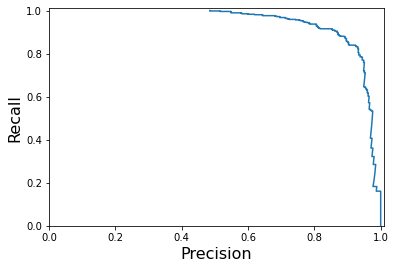

In [8]:
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

lr = LogisticRegression().fit(X_train, y_train)
y_scores_lr = lr.fit(X_train, y_train).decision_function(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_scores_lr)

plt.figsize=(30, 25)
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.plot(precision, recall, label='Precision-Recall Curve')
plt.xlabel('Precision', fontsize = 16)
plt.ylabel('Recall', fontsize = 16)
plt.show()

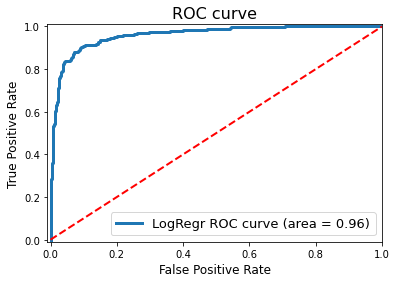

In [9]:
y_score_lr = lr.fit(X_train, y_train).decision_function(X_test)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_score_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figsize=(30, 25)
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.show()

## Grid Search

Performing a grid search over the hyper-parameters listed below for a Logistic Regression classifier, optimizing for classifier **precision** for scoring and five-fold cross validation. 

we will be adhering to the following points:
 * Using the 'liblinear' solver, which supports both L1 and L2 regularization.
 * Setting `random_state=42`, since the solver uses randomization internally.

`'penalty': ['l1', 'l2']`

`'C':[0.005, 0.01, 0.05, 0.1, 1, 10]`

From `.cv_results_`, we will create an array of the mean test scores for each hyper-parameter combination. i.e.

|   `C`   	| `l1` 	| `l2` 	|
|:----:	|----	|----	|
| **`0.005`** 	|    ?	|   ? 	|
| **`0.01`** 	|    ?	|   ? 	|
| **`0.05`** 	|    ?	|   ? 	|
| **`0.1`**  	|    ?	|   ? 	|
| **`1`**    	|    ?	|   ? 	|
| **`10`**   	|    ?	|   ? 	|

<br>

In [10]:
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
clf = LogisticRegression()
grid_values = {'penalty': ['l1', 'l2'], 'C': [0.005, 0.01, 0.05, 0.1, 1, 10], 'solver' : ['liblinear']}
grid_clf_custom = GridSearchCV(clf, param_grid = grid_values, cv=5, scoring = 'precision')
grid_clf_custom.fit(X_train, y_train)
pd.DataFrame(grid_clf_custom.cv_results_).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.008634,0.005618,0.003150,0.004646,0.005,l1,liblinear,"{'C': 0.005, 'penalty': 'l1', 'solver': 'libli...",0.785088,0.732143,0.822511,0.816514,0.777778,0.786807,0.032342,12
1,0.025666,0.007125,0.002190,0.001189,0.005,l2,liblinear,"{'C': 0.005, 'penalty': 'l2', 'solver': 'libli...",0.833910,0.844444,0.867925,0.903846,0.864662,0.862957,0.024025,10
2,0.007296,0.007461,0.003124,0.006249,0.01,l1,liblinear,"{'C': 0.01, 'penalty': 'l1', 'solver': 'liblin...",0.821862,0.789030,0.837500,0.883621,0.837607,0.833924,0.030519,11
3,0.032651,0.009228,0.000000,0.000000,0.01,l2,liblinear,"{'C': 0.01, 'penalty': 'l2', 'solver': 'liblin...",0.858156,0.860902,0.875000,0.910853,0.884170,0.877816,0.019038,9
4,0.006451,0.007502,0.006674,0.008201,0.05,l1,liblinear,"{'C': 0.05, 'penalty': 'l1', 'solver': 'liblin...",0.887640,0.879032,0.886179,0.930894,0.882812,0.893312,0.019024,8


We will find that the mean test scores are the following:

In [11]:
mean_test_scores = np.array([[0.786807,0.833924,0.893312,0.912080,0.923213,0.917190],
                                 [0.862957,0.877747,0.904062,0.909412,0.920377,0.923976]]).transpose()
mean_test_scores

array([[0.786807, 0.862957],
       [0.833924, 0.877747],
       [0.893312, 0.904062],
       [0.91208 , 0.909412],
       [0.923213, 0.920377],
       [0.91719 , 0.923976]])

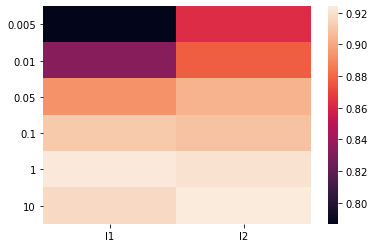

In [12]:
# We will use the following function to help visualise the results from the grid search

def GridSearch_Heatmap(scores):
    import seaborn as sns
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    plt.figsize=(30, 25)
    sns.heatmap(scores.reshape(6, 2), xticklabels=['l1','l2'], yticklabels=[0.005, 0.01, 0.05, 0.1, 1, 10])
    plt.yticks(rotation=0);

GridSearch_Heatmap(mean_test_scores)